<a href="https://colab.research.google.com/github/Angorith/acorn_python/blob/main/0616_28%EC%9D%BC%EC%B0%A8_AI(%EB%94%A5%EB%9F%AC%EB%8B%9D)%5BTwoLayerNet%2C%EC%98%A4%EC%B0%A8%EC%97%AD%EC%A0%84%ED%8C%8C%EB%B2%95(backpropagation)%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4.5 학습 알고리즘 구현**

신경망 학습 절차

학습 :  가중치 , 편향을 훈련 데이터에 적응하도록 조정하는 과정

1단계 - 미니배치 : 훈련 데이터중 일부를 무작위로 가져옴. 손실 함수값을 줄이는 것이 목표

1.5 - Loss  계산 <- 순전파라고 하는 predict가 수행

2단계 - 기울기 산출 : 각 가중치의 기울기를 구함. 기울기는 손실함수의 값을 가장 작게 하는 방향을 제시

3단계 - 가중치와 편향 갱신 : 가중치와 편향을 기울기 방향으로 아주 조금 갱신

4단계 - 반복 : 1~3단계를 반복

확률적 경사 하강법 (stochastic gradient descent, SGD) : 미니 배치로 무작위로 선택하여 골라낸 데이터로 경사 하강법 실시

숫자 0, 1로 표현 : 
예) 0 90% 1 10%

In [ ]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x) #기울기 산출
        x -= lr *grad   #가중치와 편향 갱신
    return x

$$
w_i \leftarrow w_i - lr {\partial L \over \partial {w_i}}
$$

그렇다면 손실함수를 구하려면 어떻게 해야하는가?

Loss Function
softmax = 확률을 나타내는 함수

왼쪽에서 오른쪽으로 가는거 = 순전파

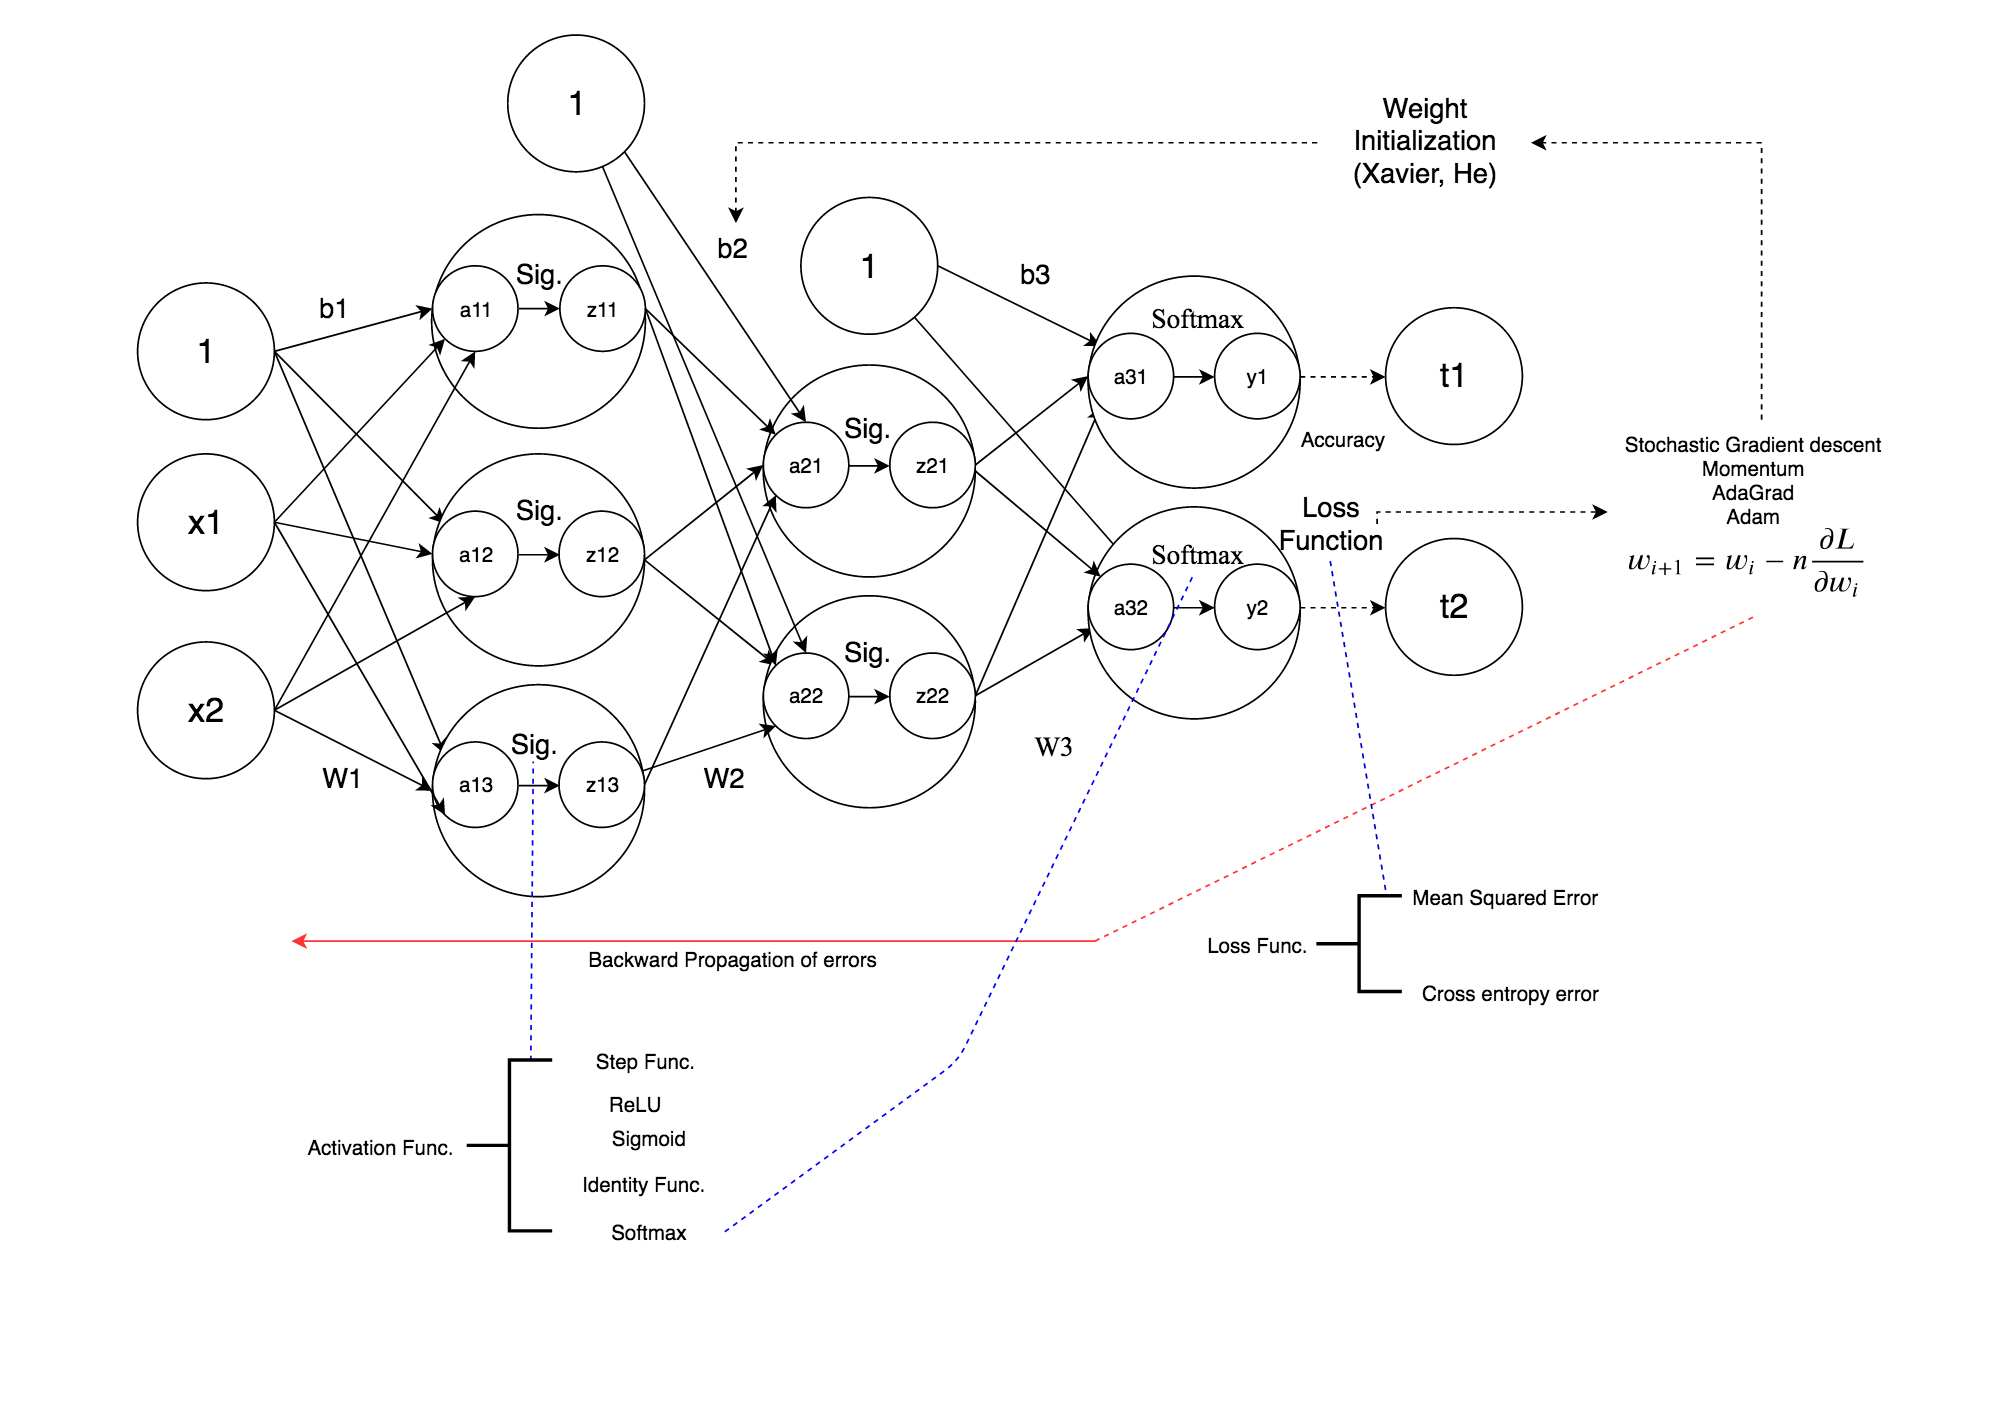

In [ ]:
import numpy as np

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))   

def numerical_gradient(f, x):
    h = 1e-4 #0.0001
    grad = np.zeros_like(x)#x와 형상이 같은 배열을 생성

    it = np.nditer(x, flags=['multi_index'],op_flags=['readwrite'])

    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx]= float(tmp_val) + h
        fxh1 = f(x)#f(x+h)

        x[idx]= tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2)/ (2*h)

        x[idx] = tmp_val #값 복원
        it.iternext()

    return grad

def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    #훈련 데이터가 원-핫 벡터 라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]))/ batch_size

def sigmoid_grad(x):
    return (1.0 - sigmoid(x))* sigmoid(x)

def softmax(x):
    if x.ndim ==2:
        #print(x)
        x = x.T     #x값 전치
        x = x-np.max(x, axis=0)
        y = np.exp(x)/np.sum(np.exp(x),axis=0)
        return y.T
    #print(x)
    x = x- np.max(x)    #Overflow 대체
    return np.exp(x)/ np.sum(np.exp(x))    


In [ ]:
import numpy as np

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01): 
        self.params={}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hidden_size)#랜덤넘버와 weight_init_std를 곱해서 가중치를 찾는다.
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    def numerical_gradient(self, x, t): #인스턴스 메서드
        loss_W = lambda W: self.loss(x,t)

        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1']) #클래스 바깥에 있는 메서드
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        #순전파와 반대인 역전파를 한다.
        #순서가 뒤로 가고 있기에 오차 역전파 라고 한다.backward Propagation of errors
        dy = (y - t) / batch_num    #오차
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [ ]:
from drive.MyDrive.mnist import load_mnist

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

In [ ]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [ ]:
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

In [ ]:
network.params['W1'].shape, network.params['b1'].shape,network.params['W2'].shape, network.params['b2'].shape

((784, 50), (50,), (50, 10), (10,))

In [ ]:
iters_num = 10000   #4단계: 1~3단계 반복을 만번
train_size = x_train.shape[0]
batch_size = 100    #
learning_rate = 0.1 #

iter_per_epoch = max(train_size / batch_size, 1)    #1 epoce 만번 다 쓸때까지 100
#손실함수 값 받는 리스트
train_loss_list = []

#정확도 받는 리스트
train_acc_list = []
#시험 데이터의 정확도
test_acc_list = []
#val loss list, val 

In [ ]:
iter_per_epoch

600.0

In [ ]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)   #1단계 데이터 중 일부를 무작위로 가져옴(그 중100개 무작위)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)   #기울기 얻었음
    for key  in ('W1', 'b1','W2', 'b2'):    #각각 매개변수(가중치)가 가중치가 되어서
        network.params[key]-= learning_rate * grad[key] #   

    loss = network.loss(x_batch, t_batch)   #ㄴ클래스에있는 loss실행
    train_loss_list.append(loss)    #loss함수값이 여기에 담김

    if i % iter_per_epoch ==0 : #600/i 나머지가 0이면 각각 리스트에 담아라
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_loss_list)
        test_acc_list.append(test_acc)        
        print('train acc test acc |' + str(train_acc) + ", " + str(test_acc))

train acc test acc |0.0993, 0.1032
train acc test acc |0.7844833333333333, 0.7886
train acc test acc |0.8754166666666666, 0.8794
train acc test acc |0.8974166666666666, 0.9012
train acc test acc |0.90815, 0.9114
train acc test acc |0.9145333333333333, 0.9161
train acc test acc |0.91965, 0.922
train acc test acc |0.9244, 0.9262
train acc test acc |0.9280166666666667, 0.9302
train acc test acc |0.93115, 0.9315
train acc test acc |0.9339166666666666, 0.9346
train acc test acc |0.93635, 0.9342
train acc test acc |0.9389, 0.9367
train acc test acc |0.9409166666666666, 0.9381
train acc test acc |0.9427833333333333, 0.9408
train acc test acc |0.9441833333333334, 0.9412
train acc test acc |0.9463333333333334, 0.9428


============

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

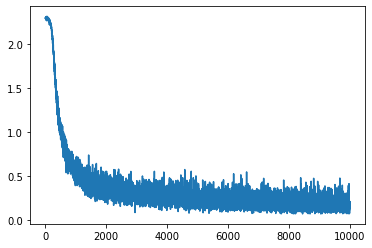

In [ ]:
plt.plot(train_loss_list)

ValueError: ignored

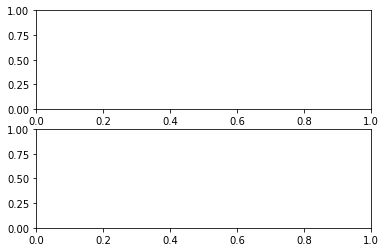

In [ ]:
f, (ax1,ax2) = plt.subplots(2, 1)
x = np.array(range(iters_num))
ax1.plot(x, train_loss_list, label='loss')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 3.0)

ax2.plot(x[:1000], train_loss_list[:1000], label='loss')
ax2.set_xlabel('iteration')
ax2.set_ylabel('loss')
ax2.set_ylim(0, 3.0)

In [ ]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [ ]:
x_batch.shape, t_batch.shape

((3, 784), (3, 10))

In [ ]:
t_batch

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
%timeit network.numerical_gradient(x_batch, t_batch)

1 loop, best of 5: 8.31 s per loop


In [ ]:
%timeit network.gradient(x_batch, t_batch)

The slowest run took 7.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 230 µs per loop


In [ ]:
network.params['W1']

array([[-0.00777859,  0.00367571,  0.00642152, ...,  0.0025704 ,
         0.00236241, -0.00147014],
       [-0.01747928,  0.00020963, -0.0086726 , ..., -0.00726639,
         0.00310548,  0.01506576],
       [ 0.00626265,  0.00640796,  0.00144558, ...,  0.0082872 ,
         0.01082036,  0.00090783],
       ...,
       [-0.00372898, -0.00257074,  0.0059776 , ...,  0.01274124,
        -0.00198691, -0.00523021],
       [-0.00879865, -0.0082203 ,  0.01193236, ...,  0.00563252,
         0.00341021, -0.01406091],
       [-0.00753998,  0.00844359,  0.01456891, ..., -0.00820823,
         0.00473774,  0.00748969]])

5. 오차역전파법

오차역전파법(backpropagation) : 가중치

5.1 